# 細胞画像から細胞状態を直接予測する

今までは、細胞の大きさなどを観測した後に、芽の大きさで細胞周期を分けることを考えていましたが、ここでは、画像から直接細胞状態を推定する予測器を作成します。手間のかかる特徴量の抽出を無くせるという利点がある一方で、どの特徴が重要で分類できたのかは分かりにくくなるので、目的によって、適切に使い分けてください。

深層学習のサンプルとして、数字のMNIST、画像のImageNetなどの定形データに対する解析方法は、いずれの深層学習フレームワークでもドキュメントに書かれていますが、データ形式が少し変化したりすると、とたんにドキュメントが少なくなる現状のため、この講義では、生命科学ではよくあるだろうシチュエーションのデータ形式を考えつつ、サンプルを用意します。難解だとおもったら、PyTorchのチュートリアルなどを見て、再度このドキュメント・プログラムを見てもらえればと思います。

## ライブラリの読み込み

2節同様に、利用するライブラリ一群を読み込みます。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.utils.data as data
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import copy
import argparse
import time
import numpy as np
import pandas as pd

## データの読み込み

特徴量から読み込んだ事例では、学習開始前に全てのデータを読み込み、学習時には、そこからバッチ毎にデータを読み込んでいました。画像の場合も同様ですが、ここでは、大規模データに対応できる工夫を導入します。

画像や動画の場合には、枚数が多くなるとメモリに乗らない分量の大規模なデータになることがあります。このような場合には、学習前に全てのデータを読み込むことはできません。そこで、学習前にはファイル名（あるいは、ファイル名を知るために必要な値）だけを読み込み、バッチ毎に、バッチ内にあるサンプルの画像や動画を読み込みます。これにより、バッチ対象となるデータが読み込みさえすれば、学習を進めることができるので、全データ分のメモリが用意できなくても学習が可能です。

さらに、このバッチごとの読み込みには複数の利点があります。

* 深層学習では、高速化のためCPUではなくGPUを利用した計算が行われますが、GPUの欠点として、メモリが少ないことが挙げられます。たとえば、現在よく使われるNVIDIA社のGTX1080で8GB、サーバ用途で利用されるNVIDIA社のTESLA V100で16GB〜32GBと、CPUから利用できるメモリに比べると少々少なくなっています。バッチごとのデータ読み込みが可能になることで、メモリ量が限られた環境でも、効率良い学習が可能になります。
* データの擬似的な拡張(水増し：Augmentation)との相性が良いです。例えば、画像解析を考えた場合に、上下左右の反転をしたり、回転をしても、同一のクラスとして認識して欲しい場合が多くあります（カメラを傾けても、ネコはネコなので）。この場合、画像を適当な角度で回転して、学習しても構わないことになります。予め、様々な角度の画像を用意しておくことも、一つの作戦ですが、ただでさえ枚数が多い画像が更に多くなって、ハードディスク容量の圧迫に繋がる可能性があります。そこで、バッチ毎に画像を読み込む際に、乱数を発生させて、適当な角度に回転したり、上下左右を入れ替えたりすることで、あらたなデータを予め用意することなく、水増しが可能になります。

以下のプログラムでは、make_dataset 関数が、特徴量同様に学習前に呼び出される関数です。この時、特徴量ではなく、画像のファイル名を作成し、酵母画像のファイル名とクラスの対応表を作成しています。
画像は、PhotoID列をX, CellID列をYとすると、```data/images/C_yor202w_0_0_X_Y.png``` に入っています。よって、各細胞に対して、このファイル名と、クラスを割り当てます。クラスが"no", "small","medium","large" をそれぞれ別の次元とした4次元で表すのは、前節の事例と同じです。

In [2]:
def make_dataset(dir):
    images = []
    labels = []
    dataset = pd.read_csv(os.path.join(dir, "yeast_his3.csv"))
    for _, row in dataset[["Cgroup","PhotoID", "CellID"]].iterrows():
        filename = "C_yor202w_0_0_%d_%d" % (row["PhotoID"], row["CellID"])
        image_path = os.path.join(dir, "images", filename + ".png")
        y = [0, 0, 0, 0]
        if row["Cgroup"] == "no":
            y = [1, 0, 0, 0]
        elif row["Cgroup"] == "small":
            y = [0, 1, 0, 0]
        elif row["Cgroup"] == "medium":
            y = [0, 0, 1, 0]
        elif row["Cgroup"] == "large":
            y = [0, 0, 0, 1]
        images.append(image_path)
        labels.append(np.array(y))
    return images, labels


前節同様に、訓練データ、バリデーションデータ、テストデータで分割を実施しましょう。

In [3]:
# 全体を、training, valid, testに分ける。ここでは、3:1:1 に分割。
# training + valid が、機械学習の training data 相当。
datadir = "data"
X, y = make_dataset(datadir)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size = 0.25
)

前節では、各バッチでは、DatasetFolder内の値を読み出していました。ここでも同様ですが、前節では、値を読み出すときには、PyTorchのTensor型に変換をしていたところを

* 指定したパスの画像情報を読み出す (pil_loader関数)
* 必要に応じて、画像の大きさを変換する (後述)。もしくは、水増しを行う。
* 色の正規化を行う（後述）

などの操作を追加します。

In [4]:
class DatasetFolder(data.Dataset):
    def __init__(self, X, y, loader, transform=None, target_transform=None):
        self.loader = loader
        self.samples = X
        self.targets = y
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.targets[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.samples)


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

画像読み込み時の、画像サイズの変換や色の補正を実施します。

前節の事例では、特徴量も、クラスも、また、訓練、バリデーション、テストのいずれでも、一律に変換をしていました。ここでも訓練、バリデーション、テストのいずれでも基本的に一律の変換を実施しますが、特徴量は画像に変わっているため、画像特有の変換が実施できるように、それぞれ独立して定義を行います。

In [6]:
# 画像の輝度値を補正するための関数を設定。
# ResNet等のPre-trained model 学習時に利用されていた値
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# 画像の幅と高さ
WIDTH = 224
HEIGHT = 224

# training (validation, testも同様）時に、画像に対して変換を加える場合は、
# ここに記述する。ResizeやFlipなど。
# 参照：https://pytorch.org/docs/stable/torchvision/transforms.html
# 変換のあと、pytorchで扱うために、Tensor型に変換してあげる必要あり。
# normalize(上記の関数)は、Tensor型に変換したあと、実施
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        #normalize　# 後で画像を表示するために、一旦コメントアウトしておく。
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

# クラスの変換。今回はPytorchのテンソルに変換するだけ
# 他に必要な変換がある場合には、画像同様に記載可能。
class ToTensorOfTarget(object):
    def __call__(self, target):
        return torch.from_numpy(target)

target_transforms = transforms.Compose([
        ToTensorOfTarget()
])

# 画像とクラスの読み込み用の関数を定義
image_datasets = {
    'train':DatasetFolder(X_train, y_train, pil_loader,
                              data_transforms['train'],
                              target_transforms),
    'val':DatasetFolder(X_val, y_val, pil_loader,
                             data_transforms['val'],
                             target_transforms),
    'test': DatasetFolder(X_test, y_test, pil_loader,
                             data_transforms['test'],
                             target_transforms)
}


以上の準備が正しくできていることを確認するため、image_datasetsを呼び出して、帰ってくる画像を表示してみます。

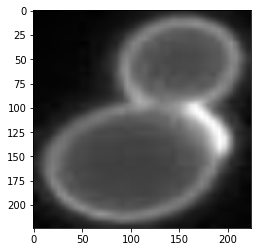

In [7]:
sample_id = 3
sample_img, _ = image_datasets['train'][sample_id]
sample_img = transforms.ToPILImage('RGB')(sample_img) # Tensor を画像に変換（もとに戻す）
plt.figure()
plt.imshow(sample_img)
plt.show()

画像を表示しやすいように、標準化をコメントアウトしていたので、戻します。

In [8]:
data_transforms = {
    # training data用。必要ならaugmentation(Flipや切り出し)を行う
    # 今は、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    # test用。こちらもFlip等は実施しない
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

バッチごとの読み込み用の設定。前節と同様。

In [9]:
# バッチサイズ分のデータを読み込む。
# training はデータをシャッフルし、読み込み始める画像をランダムにする。
# 他はシャッフルの必要なし。
batch_size=64
workers=0
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        shuffle=True,
        num_workers=workers),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        shuffle=False,
        num_workers=workers)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

## ネットワークアーキテクチャ

画像解析で広く使われるResNetなどの固定したアーキテクチャもありますが、ここでは汎用性に重きをおいて、シンプルなCNNの記載からスタートします。

ここでは、
```入力画像 -> Conv2D -> ReLU -> MaxPooling -> Conv2D -> ReLU -> MaxPooling -> Linear -> ReLU -> Linear ```
という形のネットワークを組みます。

ToDO: ConvolutionやPoolingが何であるかの説明。図が必要？

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=(1,1))
        self.fc1 = nn.Linear(16 * 56 * 56, 120) # channel_num * x * y
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        # ** convolution layers **
        # 224 x 224 -> 112 x 112 
        x = self.pool(F.relu(self.conv1(x)))
        # 112 x 112 -> 56 x 56
        x = self.pool(F.relu(self.conv2(x)))
        # convert to 1-dim
        x = x.view(-1, 16 * 56 * 56) # channel_num * x * y
        # ** classification layers **
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv1とconv2が、2次元（＝画像）のコンボリューションを実施する層になっています。poolはプーリング層、fc1とfc2は全結合層です。
* nn.Conv2d(3, 6, 5, padding=(2,2)): 3チャンネル(=RGB)の入力を、6チャネルに拡張。
* nn.MaxPool2d(2, 2): 2x2のマス目でMaxPooling を実施。
* ... 
と、利用する層の種類のの定義が行われています。

上記の関数で定義した層を、どのように組み合わせるのか表したものが、forward 関数です。こちらでは、活性化関数としてReLUを利用して、
* x = self.pool(F.relu(self.conv1(x))): 入力画像 -> Conv2D (conv1) -> ReLU -> MaxPooling (pool)
* x = self.pool(F.relu(self.conv2(x))): -> Conv2D (conv2) -> ReLU -> MaxPooling (pool)
* x.view(-1, 16 * 56 * 56): 平滑化
* x = F.relu(self.fc1(x)): -> Linear -> ReLU
* x = self.fc2(x): 最後のclassification層

という形で、ネットワークの構成を順番に記載しています。

前節同様に、作成したネットワークは、指定するデバイスに転送します。

In [11]:
device_name = "cpu"
device = torch.device(device_name)
model = Net()
model = model.to(device_name)

## 学習ステップの定義

学習ステップの詳細を定義します。現在までに、ネットワークアーキテクチャの変更と、バッチごとのデータ取得の変更（画像を取得するように）を行いましたが、この学習しテップは、前節と全く同じ関数です。

In [12]:
def print_test_accuracy(model, criterion, optimizer, phase):
    running_loss = 0.0
    running_corrects = 0
    model.train(False)

    for inputs, labels in dataloaders[phase]:
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        #optimizer.zero_grad()

        # 訓練のときだけ履歴を保持する
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, classnums = torch.max(labels, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, classnums)

        # 統計情報
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == classnums)

    # サンプル数で割って平均を求める
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    print('On Test:\tLoss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


def train_model(model, criterion, optimizer, scheduler, outpath, num_epochs=25):
    since = time.time()
    # 途中経過でモデル保存するための初期化
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 時間計測用
    end = time.time()

    print(model)
    print()

    for epoch in range(num_epochs):
        print('Epoch:{}/{}'.format(epoch, num_epochs - 1), end="")

        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                labels = labels.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # 訓練のときだけ履歴を保持する
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, classnums = torch.max(labels, 1)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classnums)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計情報
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classnums)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\t{} Loss: {:.4f} Acc: {:.4f} Time: {:.4f}'.format(phase, epoch_loss, epoch_acc, time.time()-end), end="")

            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            end = time.time()

        print()

    time_elapsed = time.time() - since
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## 深層学習の実行

実行も、前節と同様です。つまり、深層学習を用いて画像の分類をする場合には、一見長く見えるプログラムの部分は変更の必要は無く、モデルやデータの読み込みを変更すればよいとわかります。

各エポック、１０秒以上かかりますので、表示が出なくても焦らずに待ってください。

In [21]:
epochs = 20
batch_size = 64
lr = 0.01
momentum = 0.9
outdir = "."

# モデルの初期化
model = Net()
model = model.to(device)

# Loss関数の定義。
# Regression なので、CrossEntropy から、MSELossに変更
criterion = nn.CrossEntropyLoss()
# optimizer の定義
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# 10 エポックごとに学習率を0.1倍する
# 値は、ここでは固定してしまっているが、本来は可変。
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# 実際の学習を実施する
# 結果出力用ファイルのprefix
outpath = os.path.join(outdir, "cnn_b%d_lr%f_m%f_e%d" % (batch_size, lr, momentum, epochs))
model = train_model(model, criterion, optimizer, exp_lr_scheduler, outpath, num_epochs=epochs)
# 学習が終わったら、結果を保存する。
torch.save(model.state_dict(), 'model.pkl')
# テストデータでの精度を求める
print_test_accuracy(model, criterion, optimizer, 'test')


Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)

Epoch:0/19	train Loss: 1.3651 Acc: 0.3274 Time: 6.5277	val Loss: 1.3378 Acc: 0.2895 Time: 1.2515
Epoch:1/19	train Loss: 1.3006 Acc: 0.3673 Time: 6.8330	val Loss: 1.2468 Acc: 0.4605 Time: 1.1335
Epoch:2/19	train Loss: 1.1379 Acc: 0.5619 Time: 6.6124	val Loss: 1.1576 Acc: 0.5132 Time: 1.4079
Epoch:3/19	train Loss: 0.8897 Acc: 0.6372 Time: 7.0189	val Loss: 1.1721 Acc: 0.5526 Time: 1.3390
Epoch:4/19	train Loss: 0.7194 Acc: 0.6814 Time: 6.9666	val Loss: 1.3092 Acc: 0.5000 Time: 1.3373
Epoch:5/19	train Loss: 0.8909 Acc: 0.6858 Time: 7.0082	val Loss: 1.2163 Acc: 0.4868 Time: 1.3852
Epoch:6/19	train Loss: 0.6414 Acc: 0.7522 Time: 6.

私が実験した範囲では、強い初期値依存性があるので、何度か繰り返してみて、結果を確認してみてください。

多くのケースで、訓練データでは精度が高くなり（０．８等を超える）ますが、バリデーションデータやテストデータでは、訓練データに比べると低い（0.5など）値となります。この様な状態は、過学習(overfit)である可能性が高いです。深層学習では、このようなシンプルなモデルでもパラメータ数がデータ数に比べて極端に多いので、頻繁に過学習が起こります。

### Augmentation (水増し)

過学習を避ける一つの方法として、画像の水増しがあります。ここでは、データ読み込み時に水増しをしてみましょう。
RandomHorizontalFlip()で左右反転、RandomRotationで回転を行って、向き依存性を解消することと、サンプル画像の数を増やしています。

バリデーションやテストフェーズでは、水増しを行う必要はありません（これらの画像の精度を判断したいので）

In [29]:
data_transforms = {
    # training data用。必要ならFlipやリサイズを行う
    # このサンプルでは、特段の加工は行わない。
    'train': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        normalize
    ]),
    # validation用。通常はFlip等は行わない。
    'val': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
        normalize
    ])
}

# 以下は、水増し前と同じ。
epochs = 20
batch_size = 64
lr = 0.03
momentum = 0.9
outdir = "."

model = Net()
model = model.to(device)

# Loss関数の定義。
# Regression なので、CrossEntropy から、MSELossに変更
criterion = nn.CrossEntropyLoss()
# optimizer の定義
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# 10 エポックごとに学習率を0.1倍する
# 値は、ここでは固定してしまっているが、本来は可変。
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
# 実際の学習を実施する
# 結果出力用ファイルのprefix
outpath = os.path.join(outdir, "cnn_b%d_lr%f_m%f_e%d" % (batch_size, lr, momentum, epochs))
# 深層学習の実行
model = train_model(model, criterion, optimizer, exp_lr_scheduler, outpath, num_epochs=epochs)
# テストデータでの精度を求める
print_test_accuracy(model, criterion, optimizer, 'test')


Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=4, bias=True)
)

Epoch:0/19	train Loss: 1.6472 Acc: 0.2611 Time: 6.0189	val Loss: 1.3525 Acc: 0.3553 Time: 1.2209
Epoch:1/19	train Loss: 1.3800 Acc: 0.3850 Time: 5.9550	val Loss: 1.3149 Acc: 0.3684 Time: 1.2073
Epoch:2/19	train Loss: 1.1771 Acc: 0.5088 Time: 5.9140	val Loss: 1.3169 Acc: 0.3158 Time: 1.2184
Epoch:3/19	train Loss: 1.0301 Acc: 0.5531 Time: 5.2286	val Loss: 1.2930 Acc: 0.3684 Time: 1.2204
Epoch:4/19	train Loss: 0.8683 Acc: 0.6549 Time: 6.1033	val Loss: 1.2588 Acc: 0.4211 Time: 1.2018
Epoch:5/19	train Loss: 0.7370 Acc: 0.7345 Time: 5.9110	val Loss: 1.3158 Acc: 0.4605 Time: 1.2038
Epoch:6/19	train Loss: 0.6543 Acc: 0.7389 Time: 6.

本質的に画像の枚数が不十分であることもあり、十分な精度向上は見込めませんが、手順として、このようなことが行われるということを認識して頂ければと思います。

# 積み残しの課題

何点か、このテキストで積み残している課題です。
1. ResNet等頻繁に利用されているモデルの利用。
2. それらを用いた転移学習。
3. 核以外の染色画像の利用

学習に関して本質的に対処が必要な問題として
1. 画像の枚数の確保
2. 今回は顕微鏡画像から切り出した酵母の細胞画像を利用しているが、同一視野の画像は類似の傾向があると考えられるので、その補正（テスト画像選択時に、同一視野の画像を全て除くなど）

などがあります。学習時に意図しないバイアスは頻繁に入りうるので、注意をする必要があります。